## Business Case Objective
Being Data Science team at Ad ease which is an ads and marketing based company, given task is trying to understand the user visits for different wikipedia pages for 550 days.

This analysis will further be utilised to forecast the number of views as well as to predict and optimize the ad placement for Advetising clients in order to help promoting their businesses easily, effectively, and economically.

Provided data is of 145k wikipedia pages and daily view count for each of them.

Based on that clients demographics and need, helping them to run their ads on different pages and in different languages.

## Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import re

plt.rcParams['figure.figsize'] = (15 ,8)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_time = pd.read_csv('./train_1.csv')
df_time.shape

(145063, 551)

In [3]:
df_time.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [4]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [5]:
exog_lst = []
with open('./Exog_Campaign_eng', 'r') as exog:
    exog_lst = list(map(int, [str.replace(x, '\n', '') for x in exog.readlines()][1:]))

In [6]:
len(exog_lst)

550

In [7]:
exog_lst[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Exploratory Data Analysis

In [8]:
df_time.isnull().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

In [9]:
df_time['Page'].duplicated().sum()

0

In [10]:
def page_info(txt):
    return txt[:re.search('_[a-zA-Z]+\.', txt).span()[0]]

page_info = np.vectorize(page_info)

In [11]:
def lang_info(txt):
    return re.search('_[a-z]+\.', txt).group()[1:-1]

lang_info = np.vectorize(lang_info)

In [12]:
def domain_info(txt):
    return re.search('\.[a-zA-Z.]+', txt).group()[1:]

domain_info = np.vectorize(domain_info)

In [13]:
def access_info(txt):
    return re.search(r"[a-zA-Z]+-[a-zA-Z]+", txt).group()

access_info = np.vectorize(access_info)

In [14]:
def origin_info(txt):
    return re.search(r"[a-zA-Z]+$", txt).group()

origin_info = np.vectorize(origin_info)

In [15]:
def create_feature(feature, func):
    df_page[feature] = func(df_page['Page_description'])

In [16]:
# df_time.rename(columns = {'Page': 'Page_description'}, inplace = True)
df_page = df_time[['Page']].copy().rename(columns = {'Page' : 'Page_description'})
df_page.head()

,Page_description
0,2NE1_zh.wikipedia.org_all-access_spider
1,2PM_zh.wikipedia.org_all-access_spider
2,3C_zh.wikipedia.org_all-access_spider
3,4minute_zh.wikipedia.org_all-access_spider
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...


In [17]:
create_feature('page', page_info)
create_feature('language', lang_info)
create_feature('domain', domain_info)
create_feature('access', access_info)
create_feature('origin', origin_info)

In [18]:
df_page.head()

,Page_description,page,language,domain,access,origin
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,zh,wikipedia.org,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,2PM,zh,wikipedia.org,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,3C,zh,wikipedia.org,all-access,spider
3,4minute_zh.wikipedia.org_all-access_spider,4minute,zh,wikipedia.org,all-access,spider
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,52_Hz_I_Love_You,zh,wikipedia.org,all-access,spider


In [19]:
df_page.isna().sum()

Page_description    0
page                0
language            0
domain              0
access              0
origin              0
dtype: int64

In [20]:
df_page['language'].nunique()

493

In [21]:
df_page['language'].value_counts().sort_values(ascending = False)[:11]

en         23929
ja         20427
de         18538
fr         17802
zh         17227
ru         15022
es         14073
commons     8964
www         7259
vs           146
map          135
Name: language, dtype: int64

* All the pages are in 493 distinct Languages
* Number of pages in English are highest followed by Japnese

In [22]:
df_page['access'].nunique()

1175

In [23]:
df_page['access'].value_counts().sort_values(ascending = False)[:11]

all-access                  72171
mobile-web                  34913
all-agents                  33810
X-Men                          82
tats-Unis                      72
ball-Europameisterschaft       72
pt-br                          66
ball-Weltmeisterschaft         61
X-Files                        44
Jean-Pierre                    29
Royaume-Uni                    28
Name: access, dtype: int64

In [24]:
df_page['origin'].nunique()

2

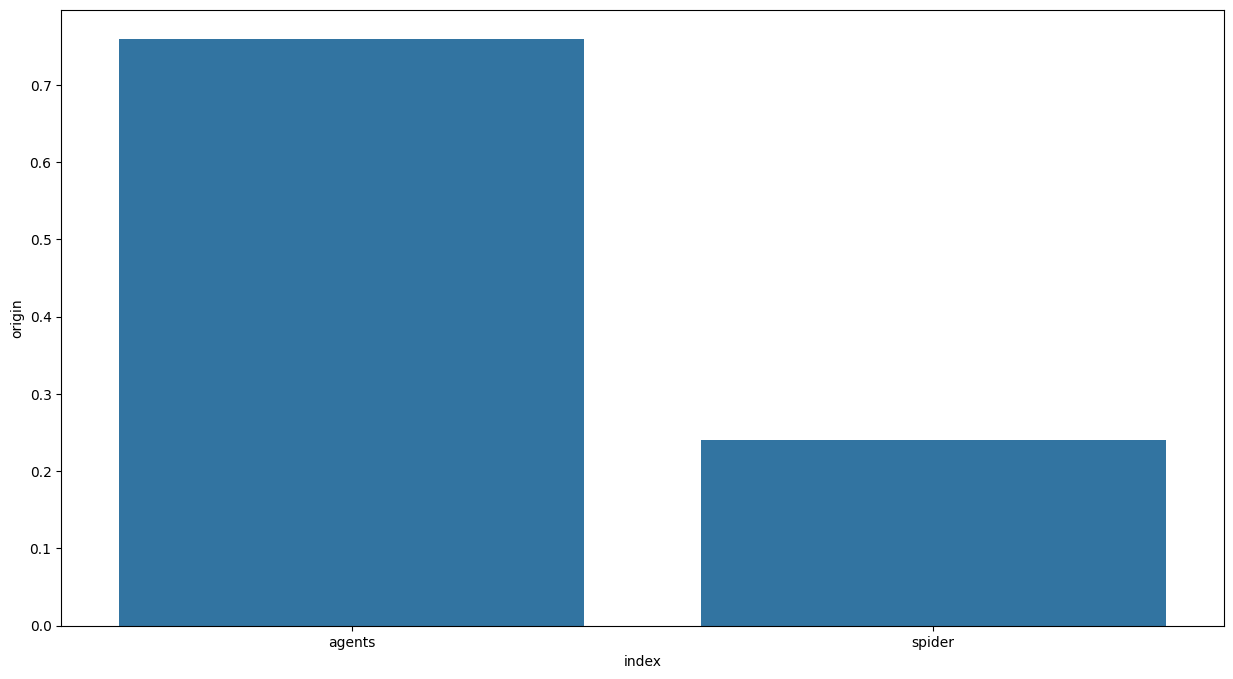

In [25]:
sns.barplot(data = df_page['origin'].value_counts(normalize = True).reset_index(), x = 'index', y = 'origin')
plt.show()

Pages with Agents accesses are almost double the size of spider

In [26]:
df_page['page'].duplicated().sum()

96061

In [27]:
df_page['page'].shape

(145063,)

In [28]:
df_page['page'].nunique()

49002

In [29]:
df_page[['page', 'language']].drop_duplicates(keep='first').groupby('page').agg('count').sort_values(by= 'language', ascending = False)[:11]

,language
page,
Special:Search,9
YouTube,8
Google,8
PlayStation_4,7
Facebook,7
Netflix,6
Apple,6
Wiki,6
xss,6


In [30]:
df_page[['page', 'access']].drop_duplicates(keep='first').groupby('page').agg('count').sort_values(by= 'access', ascending = False)[:11]

,access
page,
［Alexandros］,3
"Кинг,_Стивен",3
Киев,3
Historia_de_México,3
Киевская_Русь,3
Ким_Чен_Ир,3
Historia,3
Ким_Чен_Ын,3
Ким_Чон_Нам,3


## Feature Engineering

In [31]:
date_list = list(df_time.columns[1:])

In [32]:
df_time_trans = df_time.melt(id_vars='Page', value_vars=date_list, var_name='date', value_name='page_hits')

In [33]:
df_time_trans.head()

,Page,date,page_hits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,NaN


In [34]:
df_time_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79784650 entries, 0 to 79784649
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Page       object 
 1   date       object 
 2   page_hits  float64
dtypes: float64(1), object(2)
memory usage: 1.8+ GB


In [35]:
df_time_trans['date'] = pd.to_datetime(df_time_trans['date'])

In [36]:
df_time_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79784650 entries, 0 to 79784649
Data columns (total 3 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Page       object        
 1   date       datetime64[ns]
 2   page_hits  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.8+ GB


In [37]:
df_time_trans.head()

,Page,date,page_hits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,NaN


In [38]:
df_time_trans.shape

(79784650, 3)

In [39]:
df_time_trans.isnull().sum()

Page               0
date               0
page_hits    6192931
dtype: int64

In [40]:
df_time_trans['Page'].duplicated().sum()

79639587

In [41]:
df_time_trans['date'].min(), df_time_trans['date'].max()

(Timestamp('2015-07-01 00:00:00'), Timestamp('2016-12-31 00:00:00'))

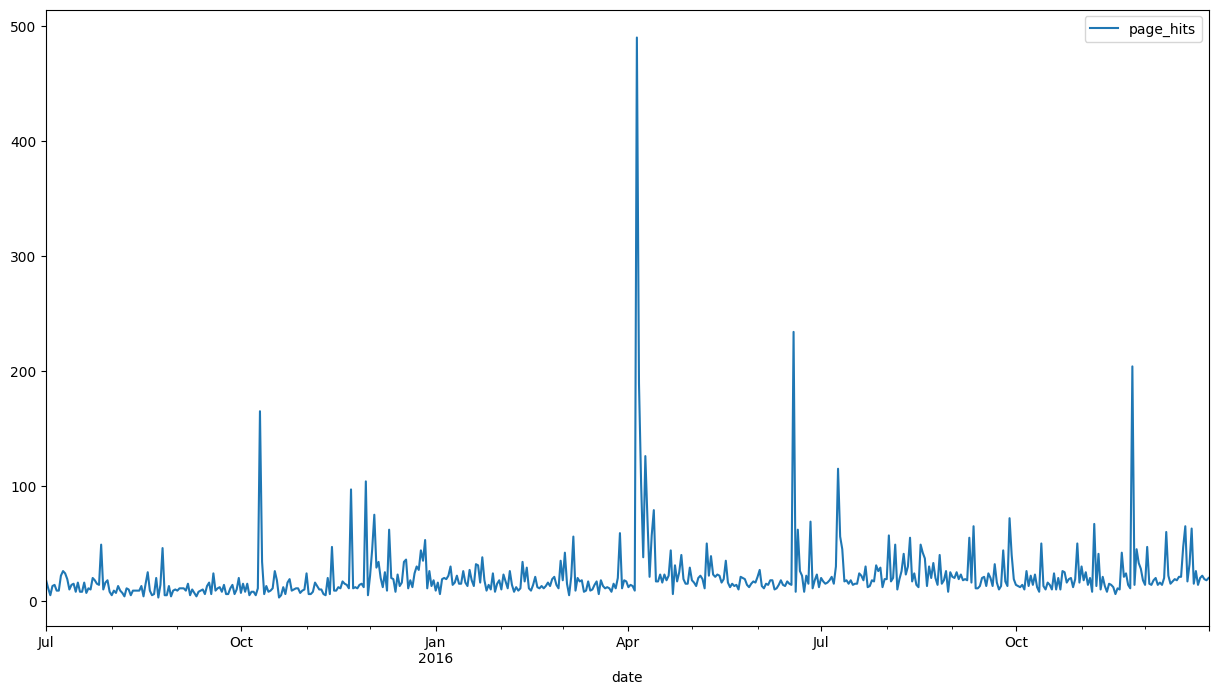

In [42]:
df_time_trans[df_time_trans['Page'] == '2NE1_zh.wikipedia.org_all-access_spider'][['date', 'page_hits']].plot(x = 'date', y = 'page_hits')
plt.show()

In [73]:
df_time_series = df_time_trans.pivot(columns = 'Page', index = 'date', values='page_hits').reset_index()
df_time_series.sort_values(by = 'date', inplace=True)

In [74]:
df_time_series.head()

Page,date,!vote_en.wikipedia.org_all-access_all-agents,!vote_en.wikipedia.org_all-access_spider,!vote_en.wikipedia.org_desktop_all-agents,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents","""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider","""Awaken,_My_Love!""_en.wikipedia.org_desktop_all-agents","""European_Society_for_Clinical_Investigation""_en.wikipedia.org_all-access_all-agents","""European_Society_for_Clinical_Investigation""_en.wikipedia.org_all-access_spider","""European_Society_for_Clinical_Investigation""_en.wikipedia.org_desktop_all-agents",...,龔嘉欣_zh.wikipedia.org_mobile-web_all-agents,龔照勝_zh.wikipedia.org_desktop_all-agents,龙生九子_zh.wikipedia.org_mobile-web_all-agents,대문_commons.wikimedia.org_all-access_all-agents,대문_commons.wikimedia.org_all-access_spider,대문_commons.wikimedia.org_desktop_all-agents,［Alexandros］_ja.wikipedia.org_all-access_all-agents,［Alexandros］_ja.wikipedia.org_all-access_spider,［Alexandros］_ja.wikipedia.org_desktop_all-agents,［Alexandros］_ja.wikipedia.org_mobile-web_all-agents
0,2015-07-01,3.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,125.0,10.0,95.0,165.0,20.0,154.0,5438.0,4.0,1077.0,4345.0
1,2015-07-02,4.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,166.0,5.0,86.0,196.0,27.0,182.0,5966.0,4.0,1210.0,4737.0
2,2015-07-03,7.0,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,199.0,4.0,87.0,181.0,11.0,168.0,5727.0,3.0,1080.0,4633.0
3,2015-07-04,4.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,134.0,25.0,86.0,167.0,25.0,153.0,7036.0,6.0,1285.0,5737.0
4,2015-07-05,4.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,179.0,6.0,81.0,131.0,14.0,92.0,7078.0,9.0,1296.0,5765.0


In [75]:
df_time_series.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 0 to 549
Columns: 145064 entries, date to ［Alexandros］_ja.wikipedia.org_mobile-web_all-agents
dtypes: datetime64[ns](1), float64(145063)
memory usage: 608.7 MB


In [76]:
page_list = df_time_series.columns[1:]

In [77]:
page_list[:10]

Index(['!vote_en.wikipedia.org_all-access_all-agents',
       '!vote_en.wikipedia.org_all-access_spider',
       '!vote_en.wikipedia.org_desktop_all-agents',
       '"Awaken,_My_Love!"_en.wikipedia.org_all-access_all-agents',
       '"Awaken,_My_Love!"_en.wikipedia.org_all-access_spider',
       '"Awaken,_My_Love!"_en.wikipedia.org_desktop_all-agents',
       '"European_Society_for_Clinical_Investigation"_en.wikipedia.org_all-access_all-agents',
       '"European_Society_for_Clinical_Investigation"_en.wikipedia.org_all-access_spider',
       '"European_Society_for_Clinical_Investigation"_en.wikipedia.org_desktop_all-agents',
       '"Heroes"_(David_Bowie_album)_en.wikipedia.org_all-access_all-agents'],
      dtype='object', name='Page')

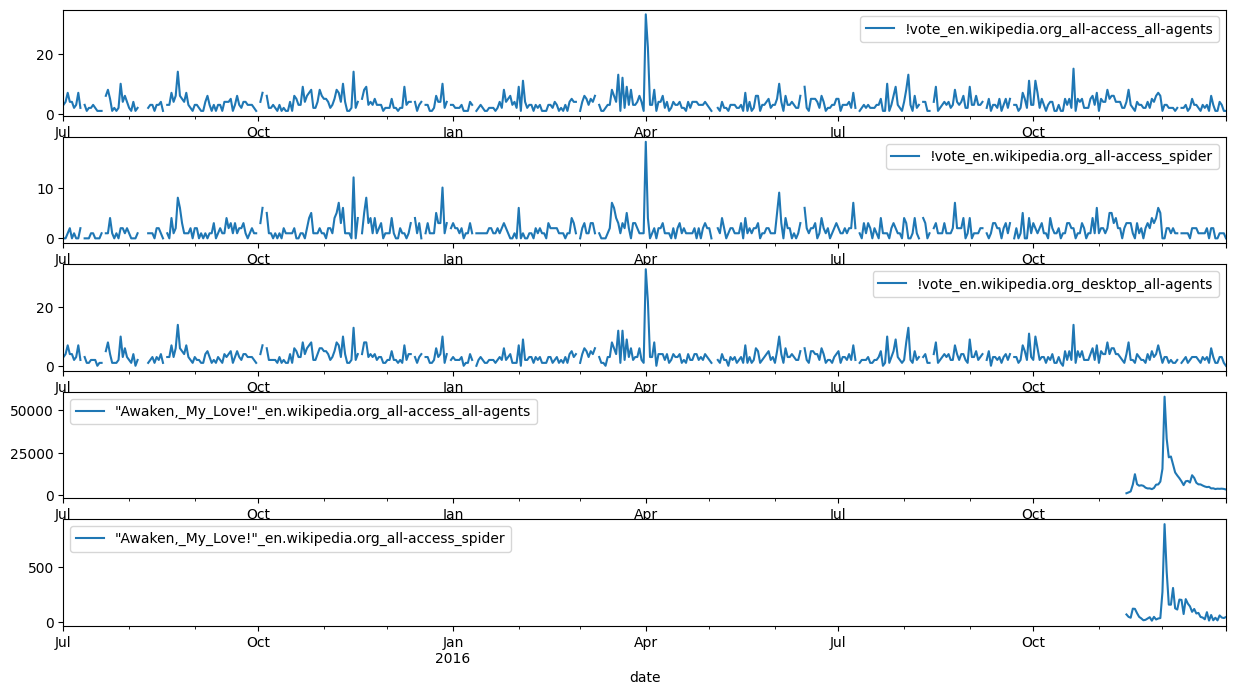

In [78]:
fig, ax = plt.subplots(5, 1)

for i in range(len(page_list[:5])):
    df_time_series.plot(x = 'date', y = page_list[i], ax = ax[i])

plt.show()

In [79]:
def remove_anomelity(series):
    lower = series.quantile(0.02)
    upper = series.quantile(0.98)
    return series.clip(upper= upper, lower = lower).interpolate(method = 'linear')

# remove_anomelity = np.vectorize(remove_anomelity)

In [80]:
df_time_series1 = df_time_series.copy()

In [83]:
df_time_series1[page_list] = df_time_series[page_list].apply(lambda x: remove_anomelity(x))

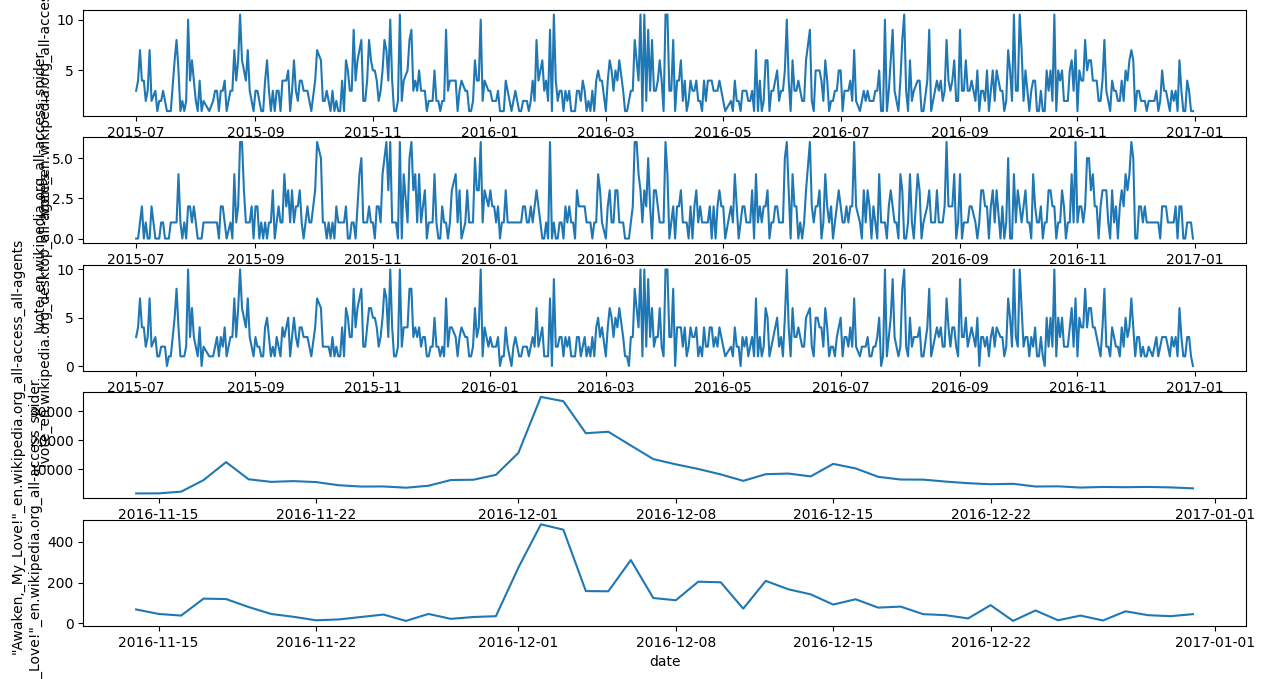

In [84]:
fig, ax = plt.subplots(5, 1)

for i in range(len(page_list[:5])):
#     sns.lineplot(x = df_time_series.date, y = remove_anomelity(df_time_series[page_list[i]]), ax = ax[i])
    sns.lineplot(x = df_time_series1.date, y = df_time_series1[page_list[i]], ax = ax[i])

plt.show()

Page,!vote_en.wikipedia.org_all-access_all-agents,!vote_en.wikipedia.org_all-access_spider,!vote_en.wikipedia.org_desktop_all-agents,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents"
0,3.0,0.0,3.0,NaN
1,4.0,0.0,4.0,NaN
2,7.0,1.0,7.0,NaN
3,4.0,2.0,4.0,NaN
4,4.0,0.0,4.0,NaN
...,...,...,...,...
545,1.0,0.0,1.0,3994.0
546,4.0,1.0,3.0,3910.0
547,3.0,1.0,3.0,4006.0
548,1.0,1.0,1.0,3841.0


In [85]:
df_time_series['exog'] = exog_lst

In [86]:
df_time_series.head()

Page,date,!vote_en.wikipedia.org_all-access_all-agents,!vote_en.wikipedia.org_all-access_spider,!vote_en.wikipedia.org_desktop_all-agents,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents","""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider","""Awaken,_My_Love!""_en.wikipedia.org_desktop_all-agents","""European_Society_for_Clinical_Investigation""_en.wikipedia.org_all-access_all-agents","""European_Society_for_Clinical_Investigation""_en.wikipedia.org_all-access_spider","""European_Society_for_Clinical_Investigation""_en.wikipedia.org_desktop_all-agents",...,龔照勝_zh.wikipedia.org_desktop_all-agents,龙生九子_zh.wikipedia.org_mobile-web_all-agents,대문_commons.wikimedia.org_all-access_all-agents,대문_commons.wikimedia.org_all-access_spider,대문_commons.wikimedia.org_desktop_all-agents,［Alexandros］_ja.wikipedia.org_all-access_all-agents,［Alexandros］_ja.wikipedia.org_all-access_spider,［Alexandros］_ja.wikipedia.org_desktop_all-agents,［Alexandros］_ja.wikipedia.org_mobile-web_all-agents,exog
0,2015-07-01,3.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,95.0,165.0,20.0,154.0,5438.0,4.0,1077.0,4345.0,0
1,2015-07-02,4.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,86.0,196.0,27.0,182.0,5966.0,4.0,1210.0,4737.0,0
2,2015-07-03,7.0,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,87.0,181.0,11.0,168.0,5727.0,3.0,1080.0,4633.0,0
3,2015-07-04,4.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,25.0,86.0,167.0,25.0,153.0,7036.0,6.0,1285.0,5737.0,0
4,2015-07-05,4.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,81.0,131.0,14.0,92.0,7078.0,9.0,1296.0,5765.0,0


In [87]:
sample_id = np.random.randint(0, len(page_list),5)
sample_id
# [nm for nm in page_list[i] for i in sample_id]


array([ 12357,  32612, 139165,  79009,  47910])

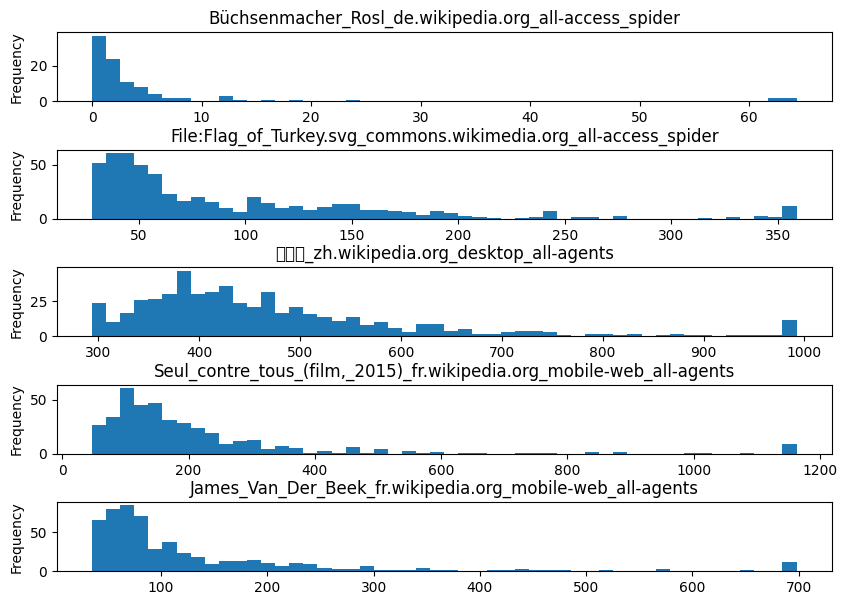

In [88]:
fig, ax = plt.subplots(5, 1, figsize=(10,7))
for i in range(len(sample_id)):
    df_time_series1[page_list[sample_id[i]]].plot.hist(bins = 50, ax=ax[i], title = page_list[sample_id[i]])
    plt.subplots_adjust(hspace = .7)

## Data Pre-processing

#### Removing pages with all NaNs + Pages with flat time-series (Constant page-hits for all the dates)

In [91]:
def preprocessing_pages(df):
    # Removing pages having more that 70% NaN
    null_count_list = pd.DataFrame(df[page_list].isna().sum().reset_index())
    null_count_list.columns = ['Page', 'null_cnt']
    all_null_data_list = null_count_list[null_count_list['null_cnt'] >= df.shape[0]*0.7]['Page']
    
    df_new = df.copy()
    df_new.drop(columns = all_null_data_list, inplace=True)
    new_page_list = df_new.columns[1:-1]
    
    # Removing pages having constant value in the data
    flat_graph_pages = []
    for page in new_page_list:
        if df_new[page].min() == df_new[page].max():
            flat_graph_pages.append(page)
            
    df_new.drop(columns = flat_graph_pages, inplace=True)
    
    print('Original Data size:', df.shape)
    print('After Pre-processing:', df_new.shape)
    
    return df_new

In [92]:
df_time_series_null_removed = preprocessing_pages(df_time_series1)

Original Data size: (550, 145064)
After Pre-processing: (550, 140564)


## checking for Stationarity

In [93]:
new_page_list = df_time_series_null_removed.columns[1:-1]

In [94]:
def stationarity_test(series):
    return adfuller(series.dropna())[1]

In [95]:
%%time
stationarity_score = df_time_series_null_removed[new_page_list].apply(lambda x: stationarity_test(x))

CPU times: user 2h 5min 54s, sys: 12min 39s, total: 2h 18min 34s
Wall time: 18min 6s


In [96]:
stationarity_score[stationarity_score > 0.05]

Page
"Heroes"_(David_Bowie_album)_en.wikipedia.org_all-access_all-agents                             0.064885
'Tis_the_Season_(Vince_Gill_and_Olivia_Newton-John_album)_en.wikipedia.org_all-access_spider    0.123112
'Tis_the_Season_en.wikipedia.org_all-access_spider                                              0.240820
'Tis_the_Season_en.wikipedia.org_desktop_all-agents                                             0.814079
...The_Stories_We_Could_Tell_en.wikipedia.org_all-access_all-agents                             0.276952
                                                                                                  ...   
龍珠超_zh.wikipedia.org_desktop_all-agents                                                         0.495572
龍珠超_zh.wikipedia.org_mobile-web_all-agents                                                      0.593805
龐茲騙局_zh.wikipedia.org_all-access_spider                                                         0.100848
龔嘉欣_zh.wikipedia.org_mobile-web_all-agents        

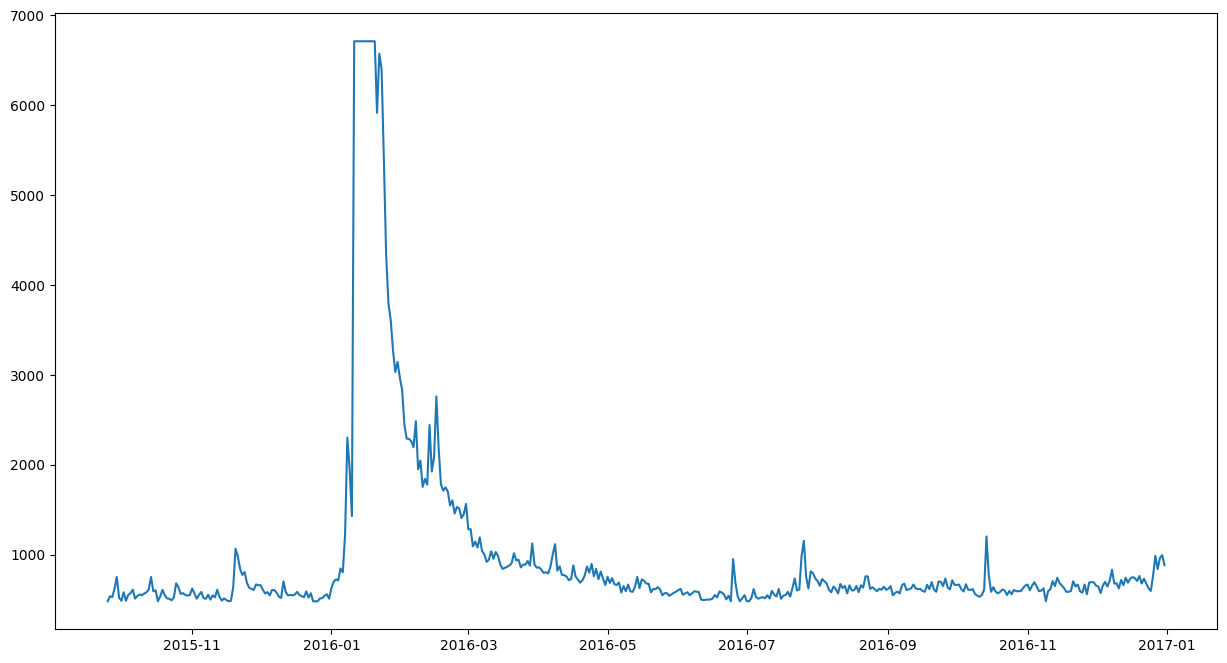

In [98]:
plt.plot(df_time_series_null_removed['date'], df_time_series_null_removed['"Heroes"_(David_Bowie_album)_en.wikipedia.org_all-access_all-agents'])

In [101]:
model = sm.tsa.seasonal_decompose(df_time_series_null_removed[['date', '"Heroes"_(David_Bowie_album)_en.wikipedia.org_all-access_all-agents']].dropna().set_index('date'), model='additive')
# model = sm.tsa.seasonal_decompose(mobile_sales.Sales, model='additive')

# type(df_time_series_null_removed['.odc_en.wikipedia.org_all-access_all-agents'])
# df_time_series_null_removed[['date', '.odc_en.wikipedia.org_all-access_all-agents']]

<Axes: xlabel='date'>

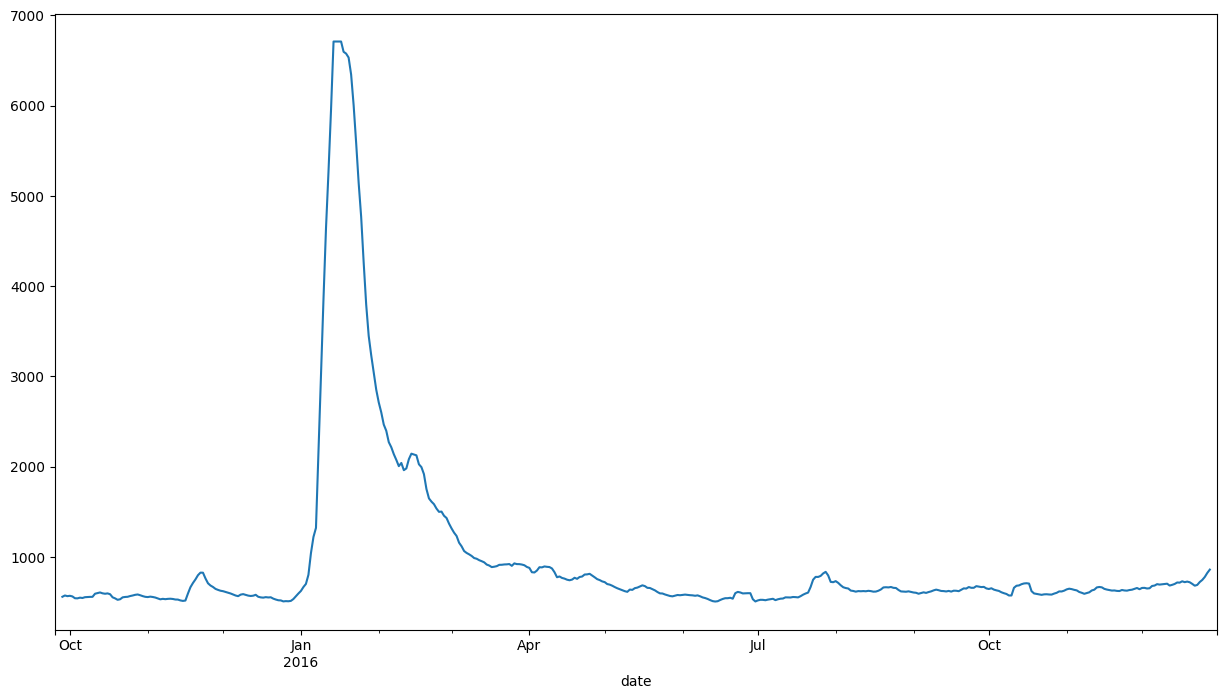

In [102]:
model.trend.plot()

<Axes: xlabel='date'>

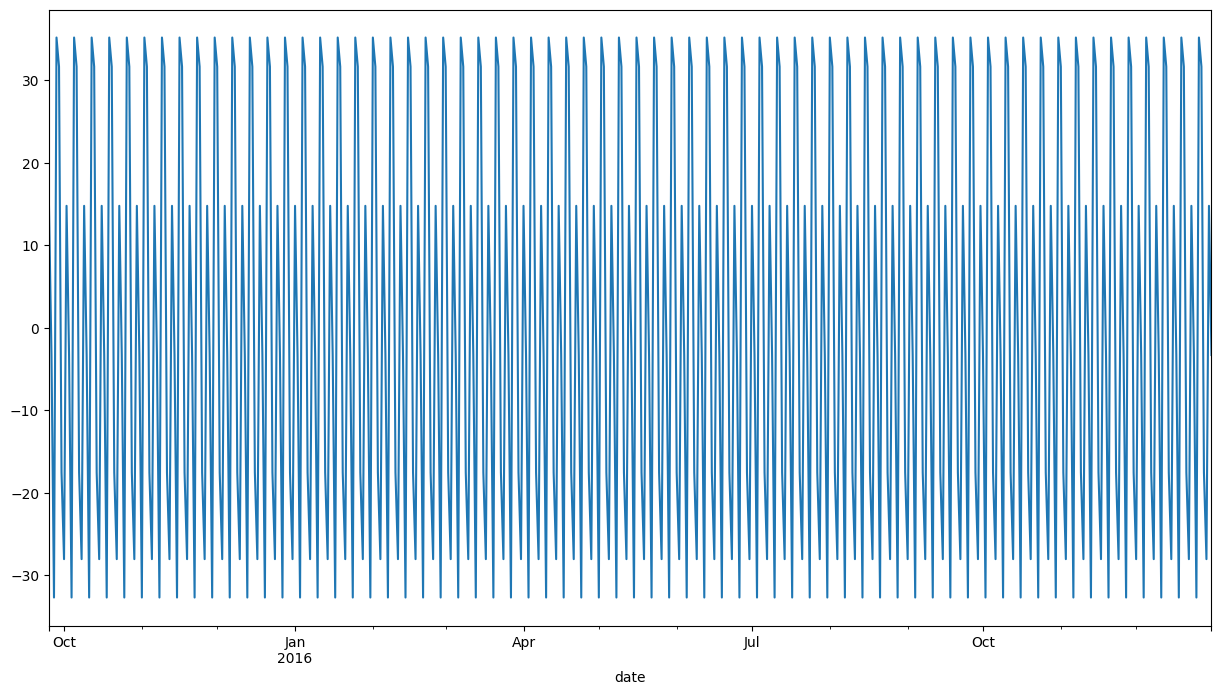

In [103]:
model.seasonal.plot()

<Axes: xlabel='date'>

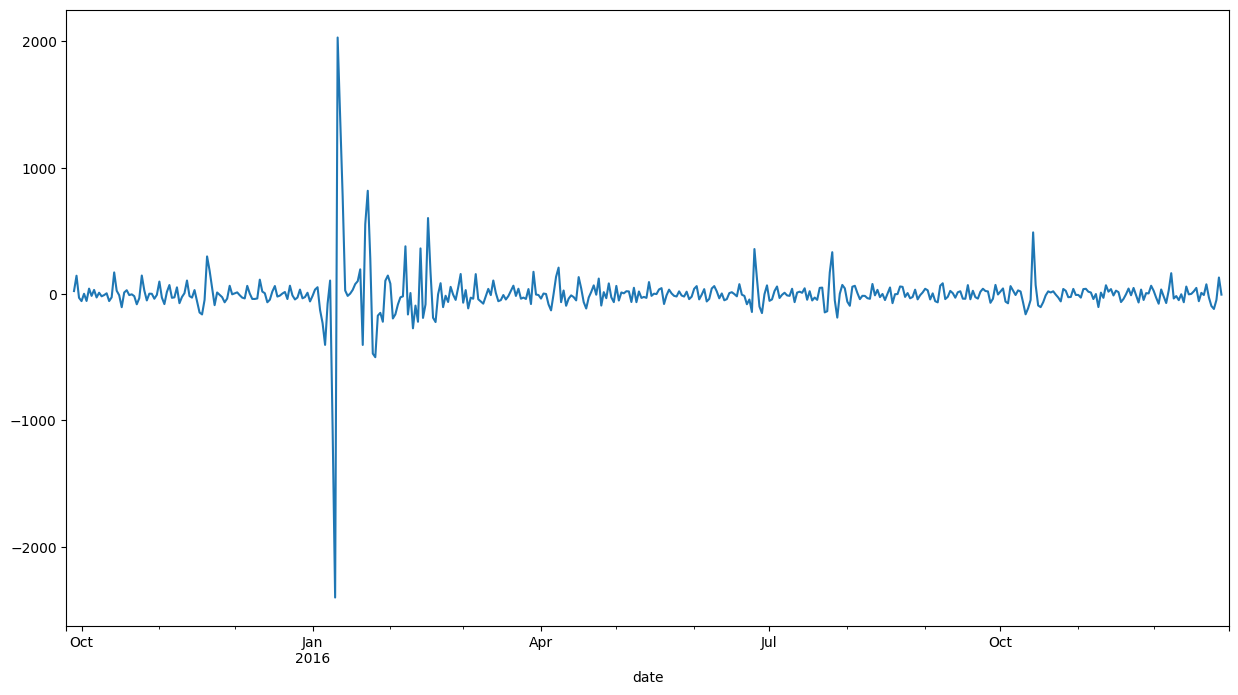

In [104]:
model.resid.plot()

In [105]:
stationarity_test(df_time_series_null_removed['"Heroes"_(David_Bowie_album)_en.wikipedia.org_all-access_all-agents'].diff())

3.4187739940552143e-10

In [110]:
np.min(len(df_time_series_null_removed) - df_time_series_null_removed[new_page_list].isna().sum())

166

In [143]:
def diff_factor_computation(df):
    diff_factor_lst = []
    for pg in new_page_list:
        for dff in range(1, 33):
            st_score = stationarity_test(df[pg].diff(dff))
            if st_score < 0.05:
                diff_factor_lst.append(dff)
                break
        else:
            diff_factor_lst.append(-1)
    
    return diff_factor_lst

In [144]:
stationarity_diff_factor = diff_factor_computation(df_time_series_null_removed)

In [134]:
# stationarity_test(df_time_series_null_removed['!vote_en.wikipedia.org_all-access_all-agents'].diff(1))

3.909679357883213e-17

In [182]:
stationarity_test(df_time_series_null_removed[new_page_list[66765]].diff(9))

1.6904338002907708e-10

In [151]:
np.unique(stationarity_diff_factor, return_counts=True)

(array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 15, 17, 18, 19,
        24]),
 array([    61, 140394,     35,     14,     16,      3,      5,      2,
             4,      3,      5,      2,      1,      6,      1,      4,
             4,      2]))

In [152]:
stationarity_diff_factor = np.array(stationarity_diff_factor)

In [190]:
np.where(stationarity_diff_factor == 5)

(array([ 11916,  43009, 106390]),)

In [159]:
len(df_time_series_null_removed) - df_time_series_null_removed[new_page_list[11916]].isna().sum()

550

In [194]:
df_time_series_null_removed[new_page_list[11916]].diff(5)

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
545    24.0
546    57.0
547     3.0
548   -45.0
549   -44.0
Name: Bärlauch_de.wikipedia.org_all-access_all-agents, Length: 550, dtype: float64

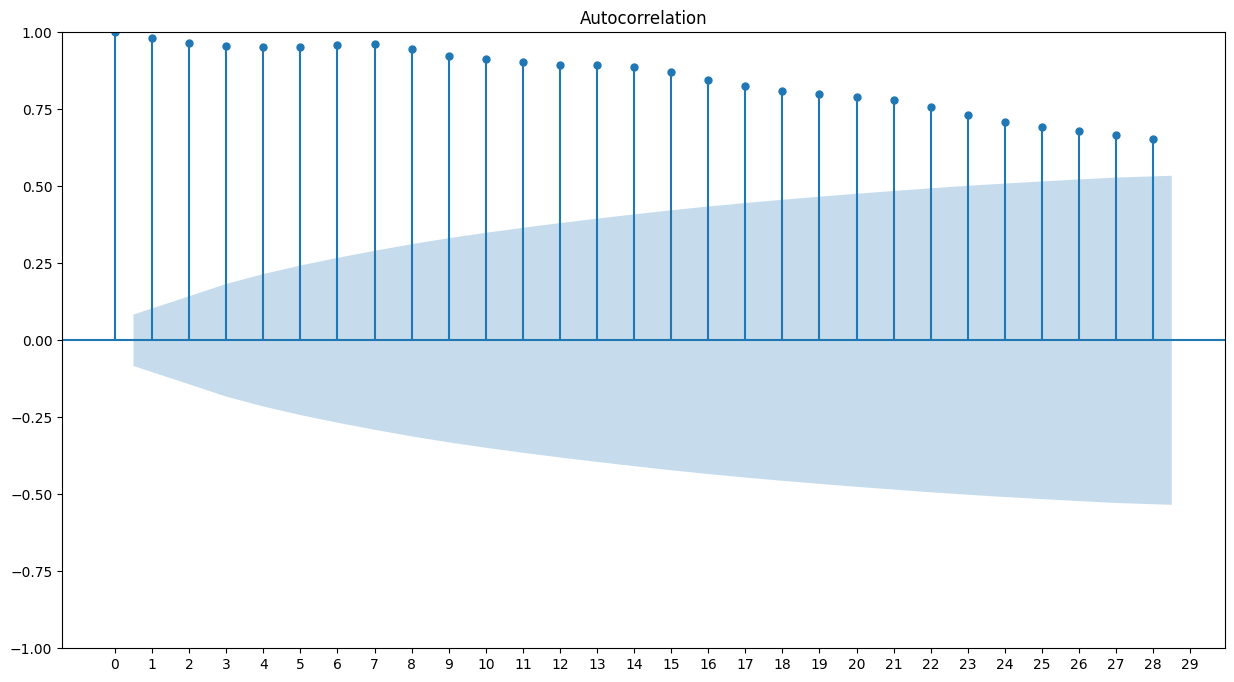

In [192]:
plot_acf(df_time_series_null_removed[new_page_list[11916]]);
plt.xticks(range(30))
plt.show()

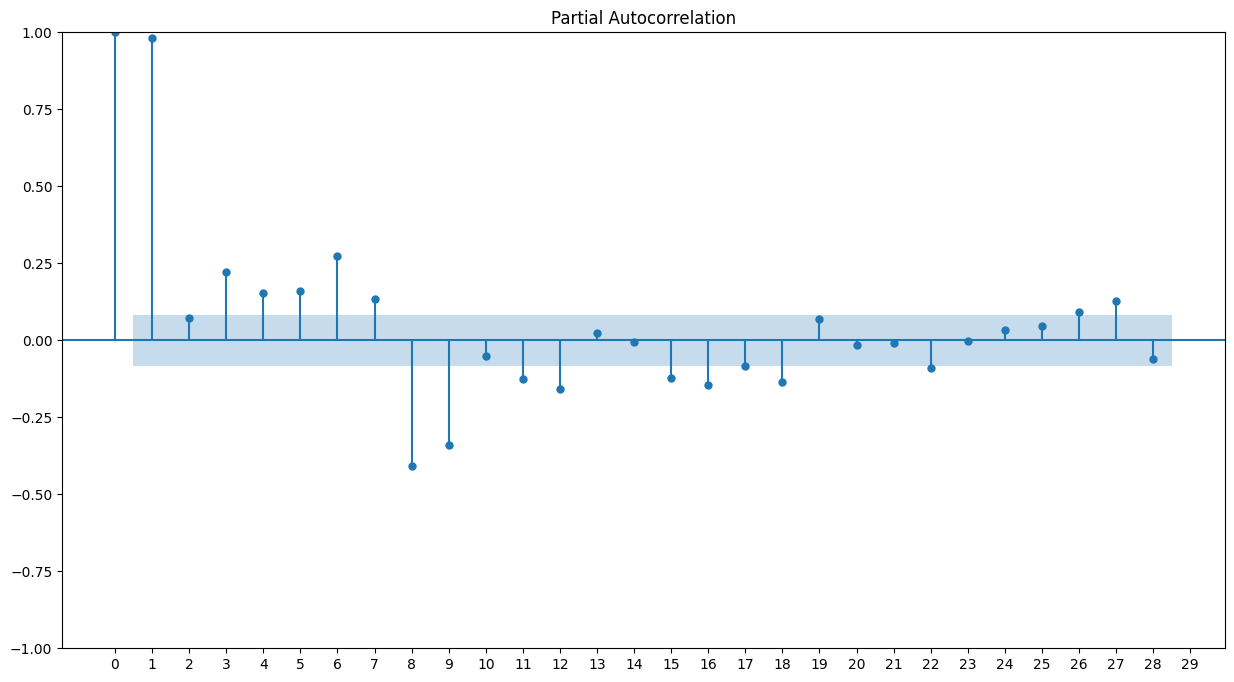

In [193]:
plot_pacf(df_time_series_null_removed[new_page_list[11916]]);
plt.xticks(range(30))
plt.show()

## Making the timeseries stationary

In [196]:
def stationary_series(df, pg_list, st_factor):
    df_new = df.copy()
    for i in range(len(pg_list)):
        if st_factor[i] != -1:
            df_new[pg_list[i]] = df[pg_list[i]].diff(st_factor[i])
        
    return df_new

In [198]:
# df_time_series_stationary = stationary_series(df_time_series_null_removed, new_page_list, stationarity_diff_factor)

## Data Engineering For Model Developement

In [ ]:
df_time_series['exog'] = exog_lst

In [208]:
df_time_series_stationary['exog'] = exog_lst

In [209]:
df_time_series_stationary_bkp1 = df_time_series_stationary_bkp.copy()
df_time_series_stationary_bkp = df_time_series_stationary.copy()

In [210]:
df_time_series_stationary_bkp.shape

(550, 140565)

In [533]:
# df_time_series_stationary = df_time_series_null_removed[['date']]
# df_time_series_stationary['exog'] = exog_lst

# choosing random 10 time-series to avoid large time for training

sample_pages = np.random.choice(new_page_list, 10)
df_time_series_stationary = df_time_series_stationary_bkp[['date', 'exog']]
df_time_series_stationary[sample_pages] = df_time_series_stationary_bkp[sample_pages]
# df_time_series_stationary[sample_pages] = df_time_series_null_removed[sample_pages]
df_time_series_stationary.head()

# df_time_series_stationary = df_time_series_stationary_bkp.copy()

Page,date,exog,España_commons.wikimedia.org_desktop_all-agents,Empire_(2015_TV_series)_en.wikipedia.org_mobile-web_all-agents,Deutsche_Fußballnationalmannschaft_der_Frauen_de.wikipedia.org_mobile-web_all-agents,Bud_Spencer_fr.wikipedia.org_all-access_all-agents,Energía_nuclear_es.wikipedia.org_mobile-web_all-agents,東海村JCO臨界事故_ja.wikipedia.org_all-access_spider,Roald_Dahl_en.wikipedia.org_mobile-web_all-agents,Gilmore_Girls_es.wikipedia.org_all-access_all-agents,スミカスミレ_ja.wikipedia.org_desktop_all-agents,雷洋事件_zh.wikipedia.org_desktop_all-agents
0,2015-07-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-07-02,0,-11.02,-2847.0,-972.82,796.0,-99.0,5.0,-423.0,32.0,NaN,NaN
2,2015-07-03,0,3.02,-363.0,-153.00,-1037.0,-90.0,-10.0,-44.0,-7.0,NaN,NaN
3,2015-07-04,0,-2.00,-442.0,1125.82,-167.0,-247.0,12.0,227.0,-8.0,NaN,NaN
4,2015-07-05,0,-1.02,709.0,0.00,378.0,119.0,-8.0,-23.0,106.0,-105.0,NaN


In [534]:
time_series_data = []
page_listing = df_time_series_stationary.columns[2:]
series_count = len(page_listing)

for i in range(series_count):
    page_timeseries = df_time_series_stationary[['date', page_listing[i], 'exog']]
    time_series_data.append(page_timeseries.dropna())

In [535]:
print('Total Series Count:', series_count)

Total Series Count: 10


In [536]:
type(time_series_data)

list

In [537]:
train_time_series_data = []
test_time_series_data = []
for i in range(series_count):
    test_size = int(np.round(time_series_data[i].shape[0]*0.2))
    train_size = time_series_data[i].shape[0] - test_size
    print(time_series_data[i].shape[0], train_size, test_size)
    
    train_time_series_data.append(time_series_data[i][:train_size])
    test_time_series_data.append(time_series_data[i][-test_size:])

549 439 110
549 439 110
549 439 110
549 439 110
549 439 110
549 439 110
549 439 110
549 439 110
546 437 109
236 189 47


In [538]:
train_time_series_data[2].shape, test_time_series_data[2].shape

((439, 3), (110, 3))

In [539]:
train_time_series_data[2].isna().sum()

Page
date                                                                                    0
Deutsche_Fußballnationalmannschaft_der_Frauen_de.wikipedia.org_mobile-web_all-agents    0
exog                                                                                    0
dtype: int64

In [540]:
train_time_series_data[2]

Page,date,Deutsche_Fußballnationalmannschaft_der_Frauen_de.wikipedia.org_mobile-web_all-agents,exog
1,2015-07-02,-972.82,0
2,2015-07-03,-153.00,0
3,2015-07-04,1125.82,0
4,2015-07-05,0.00,0
5,2015-07-06,-376.82,0
...,...,...,...
435,2016-09-08,-21.00,0
436,2016-09-09,21.00,0
437,2016-09-10,63.00,0
438,2016-09-11,-22.00,0


In [541]:
train_time_series_data[4]

Page,date,Energía_nuclear_es.wikipedia.org_mobile-web_all-agents,exog
1,2015-07-02,-99.0,0
2,2015-07-03,-90.0,0
3,2015-07-04,-247.0,0
4,2015-07-05,119.0,0
5,2015-07-06,173.0,0
...,...,...,...
435,2016-09-08,23.0,0
436,2016-09-09,-336.0,0
437,2016-09-10,-567.0,0
438,2016-09-11,255.0,0


## Defining model Performance Metrics

In [377]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)


### Creating function to measure and print all three metric
def performance(actual, predicted, plot_disp = True):
    if plot_disp:
        print('MAE :', round(mae(actual, predicted), 3))
        print('RMSE :', round(mse(actual, predicted)**0.5, 3))
        print('MAPE:', round(mape(actual, predicted), 3))
        
    return round(mape(actual, predicted), 3)

performance([100], [98])

MAE : 2.0
RMSE : 2.0
MAPE: 0.02


0.02

In [542]:
def model_performance(model, actual, last_train_val, exog, plot_disp = False):
    test_df = pd.DataFrame(actual.values, columns = ['actual'])
    test_df['pred'] = model.forecast(steps = len(actual.values), exog= exog).values
    test_df['pred'] = test_df['pred'].cumsum() + last_train_val
    mape_val = performance(test_df['actual'], test_df['pred'], plot_disp)
    if plot_disp :
        test_df.plot(style = '-o')
    return mape_val

## Creating Generic SARIMAX Model

In [242]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [522]:
# Define function
def sarimax_gridsearch(ts, pdq, pdqs, exog = [0], maxiter=10):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        exog : exogeneous list
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    if len(exog) != len(ts):
        exog = [0 for val in range(len(ts))]
    for comb in pdq:
        for combs in pdqs:
            if (comb[0] == combs[0]) and comb[0] != 0:
#                 print('same ar')
                continue
            if (comb[2] == combs[2]) and comb[2] != 0:
#                 print('same ma')
                continue
            
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=True,
                                                enforce_invertibility=False,
                                                exog = exog
#                                                 ,freq=freq
                                               )

                output = mod.fit(maxiter=maxiter, disp = False)
                
                ans.append([comb, combs, output.bic])
#                 print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except Exception as e:
                print(e)
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:1]
    
#     print(ans_df)
    output_model = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=ans_df.iloc[0]['pdq'],
                                                seasonal_order=ans_df.iloc[0]['pdqs'],
                                                enforce_stationarity=True,
                                                enforce_invertibility=False,
                                                exog = exog
                                               )
    
    return output_model.fit(maxiter=maxiter, disp = False), ans_df

## Creating AR Model

In [543]:
pdq = list((p, 0, 0) for p in range(1, 21))
PDQS = list((0, 0, 0, 0) for p in range(1))

In [544]:
print(pdq)
print(PDQS)

[(1, 0, 0), (2, 0, 0), (3, 0, 0), (4, 0, 0), (5, 0, 0), (6, 0, 0), (7, 0, 0), (8, 0, 0), (9, 0, 0), (10, 0, 0), (11, 0, 0), (12, 0, 0), (13, 0, 0), (14, 0, 0), (15, 0, 0), (16, 0, 0), (17, 0, 0), (18, 0, 0), (19, 0, 0), (20, 0, 0)]
[(0, 0, 0, 0)]


In [545]:
### Applying function to time series data ###
tr_model, tr_pdq = sarimax_gridsearch(train_time_series_data[0][page_listing[0]], pdq, PDQS)
# sarimax_gridsearch(train_time_series_data[0][page_listing[0]], pdq, PDQS)

In [546]:
# tr_pdq.iloc[0]['pdq']
tr_pdq

,pdq,pdqs,bic
12,"(13, 0, 0)","(0, 0, 0, 0)",3783.335822


In [547]:
ar_model = []
ar_pdq = []
for cntr in range(series_count):
    tr_model, tr_pdq = sarimax_gridsearch(train_time_series_data[cntr][page_listing[cntr]], pdq, PDQS)
    ar_model.append(tr_model)
    ar_pdq.append({'pdq' : tr_pdq.iloc[0]['pdq'], 'pdqs' : tr_pdq.iloc[0]['pdqs'], 'bic' : tr_pdq.iloc[0]['bic']})

In [548]:
ar_pdq

[{'pdq': (13, 0, 0), 'pdqs': (0, 0, 0, 0), 'bic': 3783.335822381954},
 {'pdq': (7, 0, 0), 'pdqs': (0, 0, 0, 0), 'bic': 7806.929475950855},
 {'pdq': (3, 0, 0), 'pdqs': (0, 0, 0, 0), 'bic': 6129.284218922428},
 {'pdq': (7, 0, 0), 'pdqs': (0, 0, 0, 0), 'bic': 6540.989365715039},
 {'pdq': (7, 0, 0), 'pdqs': (0, 0, 0, 0), 'bic': 5592.443111668733},
 {'pdq': (8, 0, 0), 'pdqs': (0, 0, 0, 0), 'bic': 3953.0333774917235},
 {'pdq': (5, 0, 0), 'pdqs': (0, 0, 0, 0), 'bic': 7396.166830725356},
 {'pdq': (2, 0, 0), 'pdqs': (0, 0, 0, 0), 'bic': 5941.925873832522},
 {'pdq': (7, 0, 0), 'pdqs': (0, 0, 0, 0), 'bic': 6125.9276617654305},
 {'pdq': (2, 0, 0), 'pdqs': (0, 0, 0, 0), 'bic': 2925.8845151046007}]

In [575]:
def st_factor_index(page_nm):
#     page_nm = 'Tournoi_des_Six_Nations_2017_fr.wikipedia.org_all-access_spider'
    for i, v in enumerate(new_page_list):
        if v == page_nm:
            break
            
    return stationarity_diff_factor[i]

for model_no in range(10):
    print(test_time_series_data[model_no].columns[1])
    print(st_factor_index(test_time_series_data[model_no].columns[1]))

España_commons.wikimedia.org_desktop_all-agents
1
Empire_(2015_TV_series)_en.wikipedia.org_mobile-web_all-agents
1
Deutsche_Fußballnationalmannschaft_der_Frauen_de.wikipedia.org_mobile-web_all-agents
1
Bud_Spencer_fr.wikipedia.org_all-access_all-agents
1
Energía_nuclear_es.wikipedia.org_mobile-web_all-agents
1
東海村JCO臨界事故_ja.wikipedia.org_all-access_spider
1
Roald_Dahl_en.wikipedia.org_mobile-web_all-agents
1
Gilmore_Girls_es.wikipedia.org_all-access_all-agents
1
スミカスミレ_ja.wikipedia.org_desktop_all-agents
1
雷洋事件_zh.wikipedia.org_desktop_all-agents
1


MAE : 62.844
RMSE : 72.596
MAPE: 8063708117523302.0


8063708117523302.0

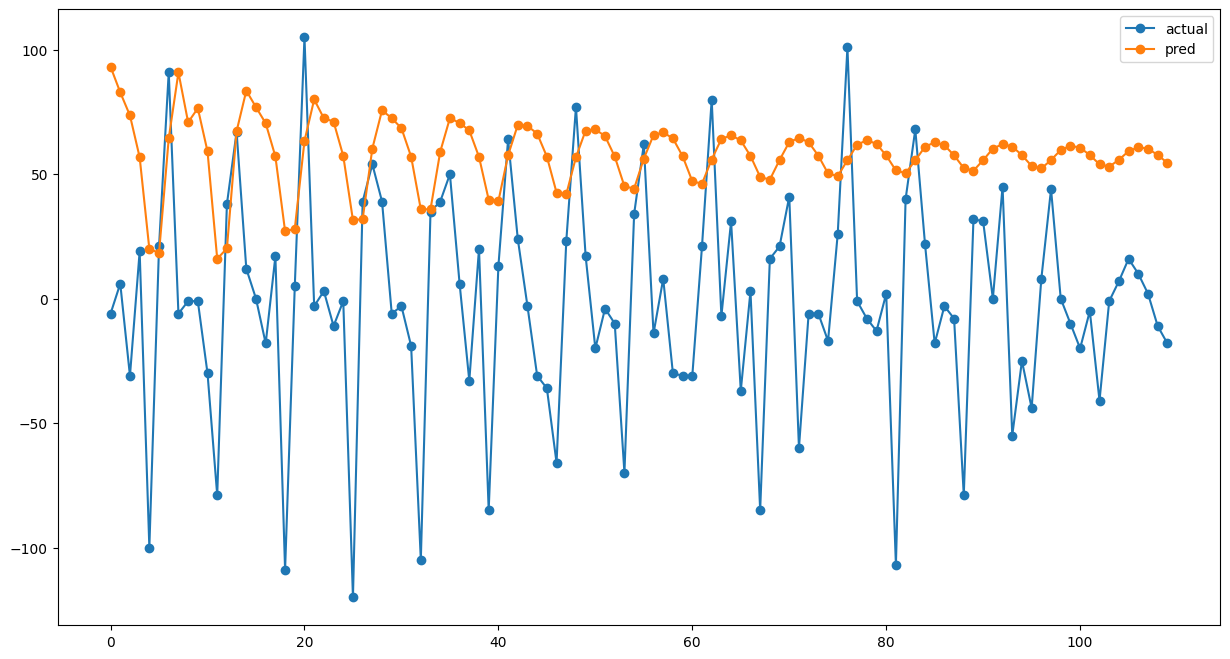

In [576]:
model_no = 0
mod = ar_model[model_no]
test_act = test_time_series_data[model_no][page_listing[model_no]]
diff_factor = st_factor_index(test_time_series_data[model_no].columns[1])
train_last_val = train_time_series_data[model_no][page_listing[model_no]].iloc[-diff_factor]
exog = [0 for val in range(len(test_time_series_data[model_no]))]

model_performance(mod, test_act, train_last_val, exog, plot_disp = True)

# train_time_series_data[model_no][page_listing[model_no]].iloc[-1]

In [577]:
ar_mape_lst = []
for cntr in range(series_count):
    mod = ar_model[cntr]
    test_act = test_time_series_data[cntr][page_listing[cntr]]
    diff_factor = st_factor_index(test_time_series_data[cntr].columns[1])
    train_last_val = train_time_series_data[cntr][page_listing[cntr]].iloc[-diff_factor]
    exog = [0 for val in range(len(test_time_series_data[cntr]))]

    
 
    ar_mape_lst.append(model_performance(mod, test_act, train_last_val, exog, plot_disp = False))
    
print('MAPE Score of AR Model:', ar_mape_lst)

MAPE Score of AR Model: [8063708117523302.0, 24.068, 2.012, 1.4347433482361694e+16, 3.081011985181185e+16, 305662999958344.1, 3.230910721549008e+17, 3.7548283153803544e+16, 2.422627326848266e+16, 1497899427034776.8]


MAE : 19.256
RMSE : 27.195
MAPE: 305662999958344.1


305662999958344.1

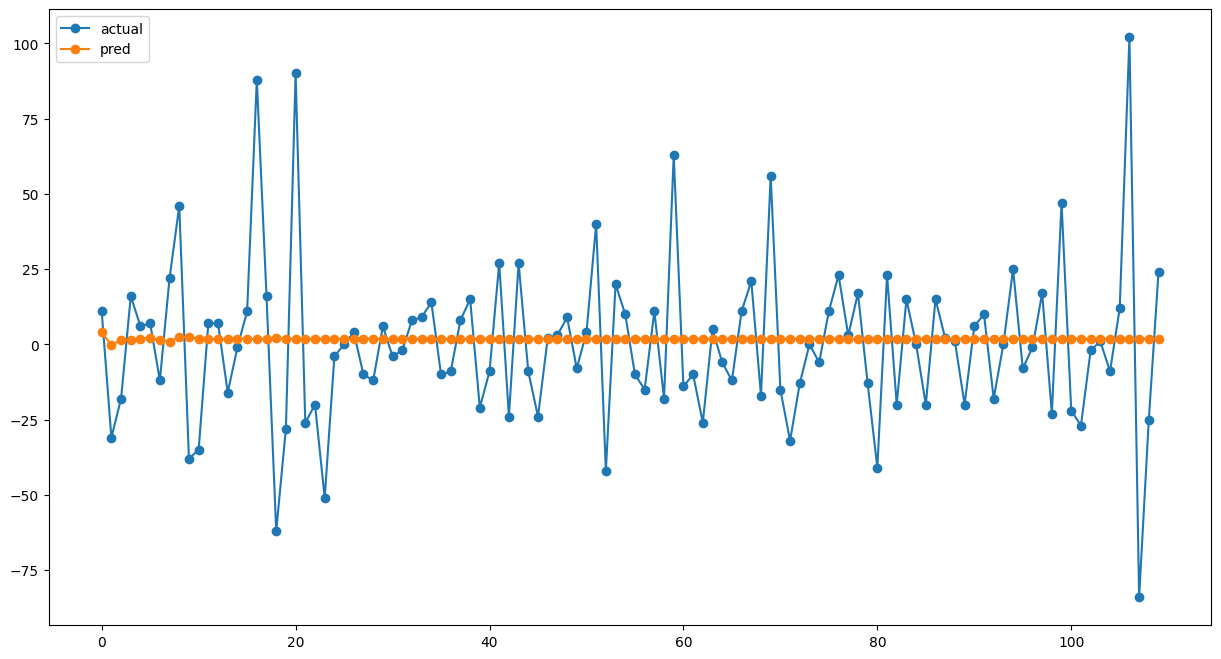

In [579]:
model_no = 5
mod = ar_model[model_no]
test_act = test_time_series_data[model_no][page_listing[model_no]]
diff_factor = st_factor_index(test_time_series_data[model_no].columns[1])
train_last_val = train_time_series_data[model_no][page_listing[model_no]].iloc[-diff_factor]
exog = [0 for val in range(len(test_time_series_data[model_no]))]

model_performance(mod, test_act, train_last_val, exog, plot_disp = True)

## Creating MA Model

In [580]:
pdq = list((0, 0, q) for q in range(1, 21))
PDQS = list((0, 0, 0, 0) for p in range(1))

In [581]:
print(pdq)
print(PDQS)

[(0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 0, 7), (0, 0, 8), (0, 0, 9), (0, 0, 10), (0, 0, 11), (0, 0, 12), (0, 0, 13), (0, 0, 14), (0, 0, 15), (0, 0, 16), (0, 0, 17), (0, 0, 18), (0, 0, 19), (0, 0, 20)]
[(0, 0, 0, 0)]


In [582]:
### Applying function to time series data ###
tr_model, tr_pdq = sarimax_gridsearch(train_time_series_data[0][page_listing[0]], pdq, PDQS)

In [583]:
# tr_pdq.iloc[0]['pdq']
tr_pdq

,pdq,pdqs,bic
8,"(0, 0, 9)","(0, 0, 0, 0)",3846.788814


In [584]:
ma_model = []
ma_pdq = []
for cntr in range(series_count):
    tr_model, tr_pdq = sarimax_gridsearch(train_time_series_data[cntr][page_listing[cntr]], pdq, PDQS)
    ma_model.append(tr_model)
    ma_pdq.append({'pdq' : tr_pdq.iloc[0]['pdq'], 'pdqs' : tr_pdq.iloc[0]['pdqs'], 'bic' : tr_pdq.iloc[0]['bic']})

In [585]:
ma_pdq

[{'pdq': (0, 0, 9), 'pdqs': (0, 0, 0, 0), 'bic': 3846.7888140187474},
 {'pdq': (0, 0, 15), 'pdqs': (0, 0, 0, 0), 'bic': 7921.929318465919},
 {'pdq': (0, 0, 3), 'pdqs': (0, 0, 0, 0), 'bic': 6133.26469489024},
 {'pdq': (0, 0, 8), 'pdqs': (0, 0, 0, 0), 'bic': 6551.463931100349},
 {'pdq': (0, 0, 9), 'pdqs': (0, 0, 0, 0), 'bic': 5949.5186209931535},
 {'pdq': (0, 0, 3), 'pdqs': (0, 0, 0, 0), 'bic': 3920.1828283091027},
 {'pdq': (0, 0, 3), 'pdqs': (0, 0, 0, 0), 'bic': 7399.524713330191},
 {'pdq': (0, 0, 2), 'pdqs': (0, 0, 0, 0), 'bic': 5935.316217796868},
 {'pdq': (0, 0, 16), 'pdqs': (0, 0, 0, 0), 'bic': 6276.197525013395},
 {'pdq': (0, 0, 2), 'pdqs': (0, 0, 0, 0), 'bic': 2914.334600909547}]

MAE : 59.029
RMSE : 70.014
MAPE: 6483379274739907.0


6483379274739907.0

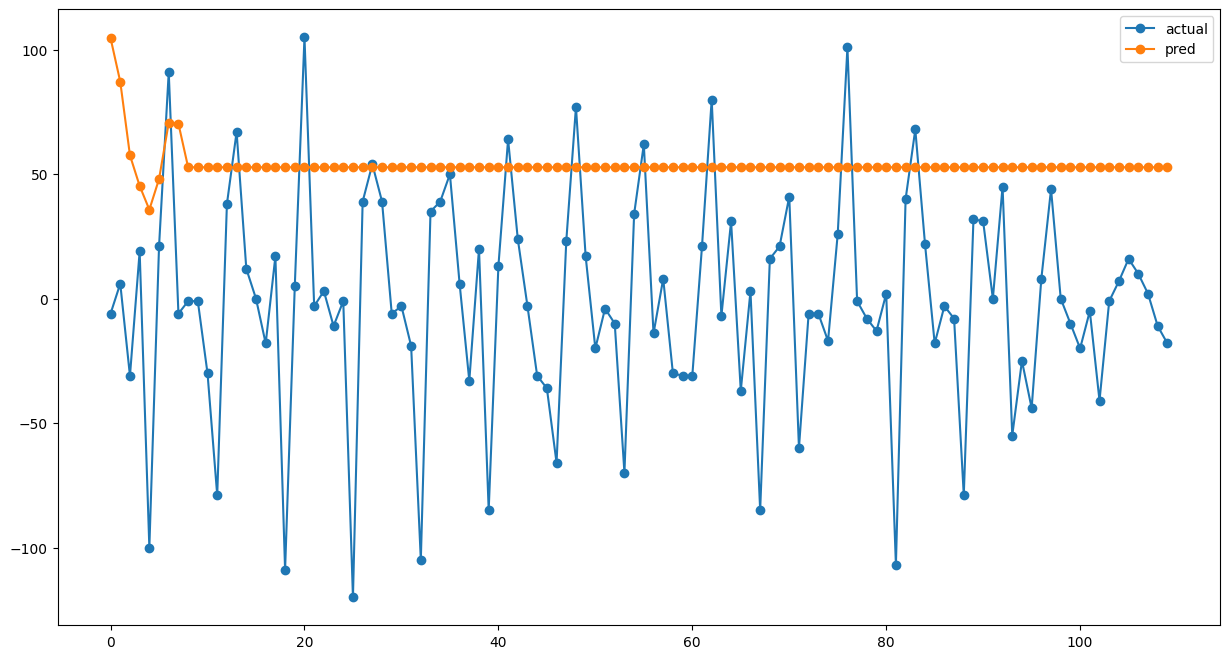

In [586]:
model_no = 0
mod = ma_model[model_no]
test_act = test_time_series_data[model_no][page_listing[model_no]]
diff_factor = st_factor_index(test_time_series_data[model_no].columns[1])
train_last_val = train_time_series_data[model_no][page_listing[model_no]].iloc[-diff_factor]
exog = [0 for val in range(len(test_time_series_data[model_no]))]

model_performance(mod, test_act, train_last_val, exog, plot_disp = True)

# train_time_series_data[model_no][page_listing[model_no]].iloc[-1]

In [587]:
ma_mape_lst = []
for cntr in range(series_count):
    mod = ma_model[cntr]
    test_act = test_time_series_data[cntr][page_listing[cntr]]
    diff_factor = st_factor_index(test_time_series_data[cntr].columns[1])
    train_last_val = train_time_series_data[cntr][page_listing[cntr]].iloc[-diff_factor]
    exog = [0 for val in range(len(test_time_series_data[cntr]))]

    
 
    ma_mape_lst.append(model_performance(mod, test_act, train_last_val, exog, plot_disp = False))
    
print('MAPE Score of MA Model:', ma_mape_lst)

MAPE Score of MA Model: [6483379274739907.0, 23.426, 2.281, 3078056491199168.5, 2.7600627590693348e+16, 700815655958670.2, 3.419338375153519e+17, 2.214118657302699e+16, 1.985977181523878e+16, 2898416081948305.0]


MAE : 19.42
RMSE : 27.485
MAPE: 700815655958670.2


700815655958670.2

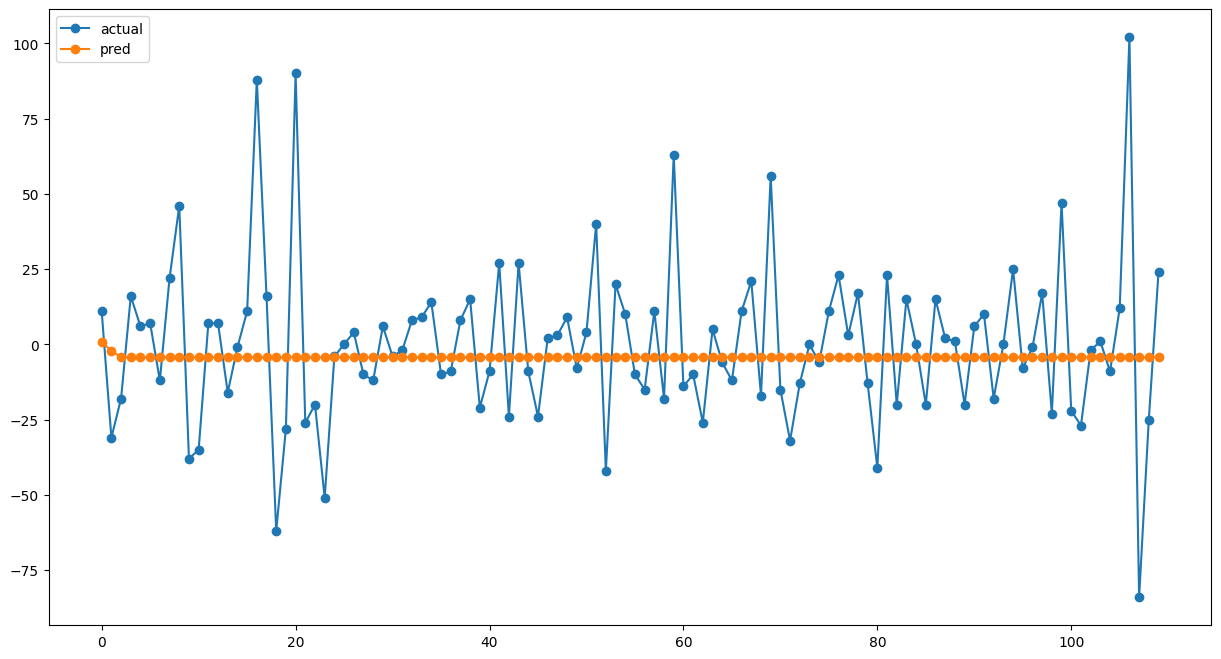

In [588]:
model_no = 5
mod = ma_model[model_no]
test_act = test_time_series_data[model_no][page_listing[model_no]]
diff_factor = st_factor_index(test_time_series_data[model_no].columns[1])
train_last_val = train_time_series_data[model_no][page_listing[model_no]].iloc[-diff_factor]
exog = [0 for val in range(len(test_time_series_data[model_no]))]

model_performance(mod, test_act, train_last_val, exog, plot_disp = True)

## Creating SARIMA Model

In [589]:
pdq = list((p, d, q) for p in range(1, 4) for d in range(1, 4) for q in range(1, 4))
PDQS = list((P, D, Q, S) for P in range(1, 4) for D in range(1, 4) for Q in range(1, 4) for S in range(2, 4))

In [590]:
print(pdq)
print(PDQS)

[(1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 3, 1), (1, 3, 2), (1, 3, 3), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 3, 1), (2, 3, 2), (2, 3, 3), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 3, 1), (3, 3, 2), (3, 3, 3)]
[(1, 1, 1, 2), (1, 1, 1, 3), (1, 1, 2, 2), (1, 1, 2, 3), (1, 1, 3, 2), (1, 1, 3, 3), (1, 2, 1, 2), (1, 2, 1, 3), (1, 2, 2, 2), (1, 2, 2, 3), (1, 2, 3, 2), (1, 2, 3, 3), (1, 3, 1, 2), (1, 3, 1, 3), (1, 3, 2, 2), (1, 3, 2, 3), (1, 3, 3, 2), (1, 3, 3, 3), (2, 1, 1, 2), (2, 1, 1, 3), (2, 1, 2, 2), (2, 1, 2, 3), (2, 1, 3, 2), (2, 1, 3, 3), (2, 2, 1, 2), (2, 2, 1, 3), (2, 2, 2, 2), (2, 2, 2, 3), (2, 2, 3, 2), (2, 2, 3, 3), (2, 3, 1, 2), (2, 3, 1, 3), (2, 3, 2, 2), (2, 3, 2, 3), (2, 3, 3, 2), (2, 3, 3, 3), (3, 1, 1, 2), (3, 1, 1, 3), (3, 1, 2, 2), (3, 1, 2, 3), (3, 1, 3, 2), (3, 1, 3, 3), (3, 2, 1, 2), (3, 2, 1, 3), (3, 2, 2, 2), (3, 2, 2, 3), (3, 2, 3, 2), (3, 2, 3, 3), (3, 3, 1, 2), (3, 3, 1, 3), (

In [591]:
sarima_model = []
sarima_pdq = []
for cntr in range(series_count):
    tr_model, tr_pdq = sarimax_gridsearch(train_time_series_data[cntr][page_listing[cntr]], pdq, PDQS)
    sarima_model.append(tr_model)
    sarima_pdq.append({'pdq' : tr_pdq.iloc[0]['pdq'], 'pdqs' : tr_pdq.iloc[0]['pdqs'], 'bic' : tr_pdq.iloc[0]['bic']})

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Invalid mo

Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Invalid mo

In [592]:
sarima_pdq

[{'pdq': (2, 1, 2), 'pdqs': (1, 1, 1, 3), 'bic': 4021.2314365538523},
 {'pdq': (2, 1, 1), 'pdqs': (3, 2, 2, 3), 'bic': 60.68425588244111},
 {'pdq': (2, 1, 1), 'pdqs': (1, 1, 3, 3), 'bic': 6265.290744581042},
 {'pdq': (1, 1, 1), 'pdqs': (3, 3, 2, 3), 'bic': 54.55311227035215},
 {'pdq': (2, 2, 1), 'pdqs': (1, 2, 3, 3), 'bic': 54.594972810933726},
 {'pdq': (2, 2, 1), 'pdqs': (3, 3, 2, 3), 'bic': 60.59123195581797},
 {'pdq': (2, 1, 2), 'pdqs': (1, 1, 1, 3), 'bic': 7574.498187304576},
 {'pdq': (2, 1, 1), 'pdqs': (1, 1, 2, 3), 'bic': 6069.547690717215},
 {'pdq': (2, 1, 2), 'pdqs': (3, 1, 1, 3), 'bic': 6443.208732294837},
 {'pdq': (2, 1, 1), 'pdqs': (3, 2, 3, 3), 'bic': 57.24407355784474}]

MAE : 139.151
RMSE : 152.313
MAPE: 1.9283217962299852e+16


1.9283217962299852e+16

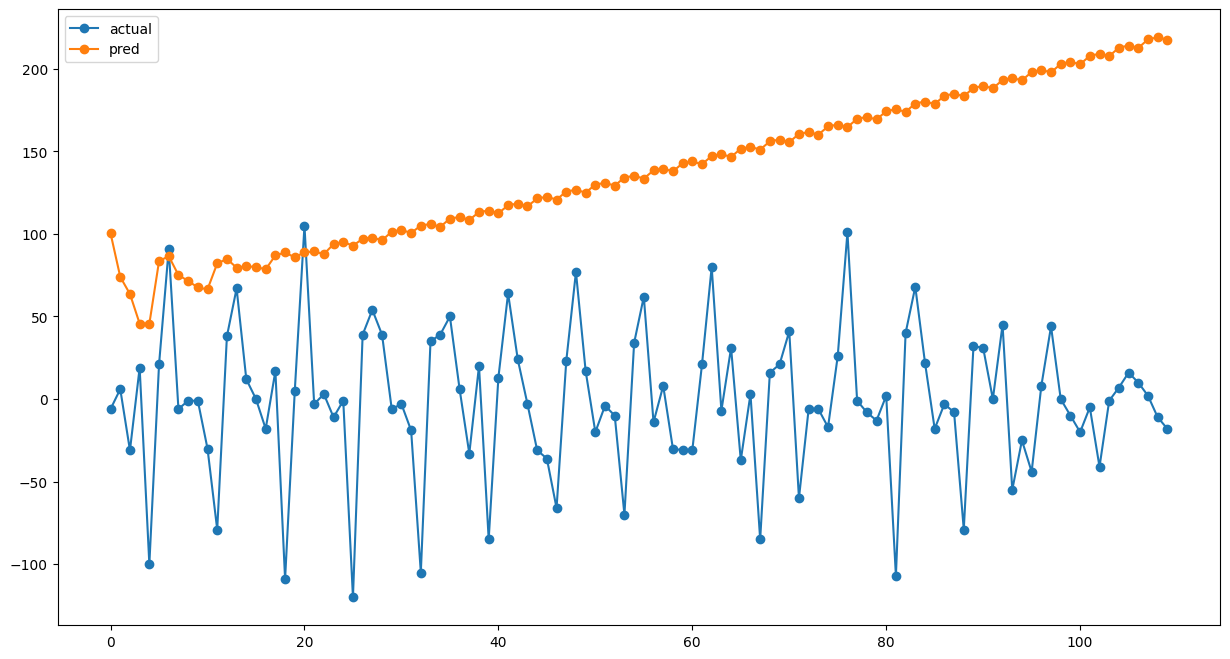

In [593]:
model_no = 0
mod = sarima_model[model_no]
test_act = test_time_series_data[model_no][page_listing[model_no]]
diff_factor = st_factor_index(test_time_series_data[model_no].columns[1])
train_last_val = train_time_series_data[model_no][page_listing[model_no]].iloc[-diff_factor]
exog = [0 for val in range(len(test_time_series_data[model_no]))]

model_performance(mod, test_act, train_last_val, exog, plot_disp = True)

# train_time_series_data[model_no][page_listing[model_no]].iloc[-1]

In [594]:
sarima_mape_lst = []
for cntr in range(series_count):
    mod = sarima_model[cntr]
    test_act = test_time_series_data[cntr][page_listing[cntr]]
    diff_factor = st_factor_index(test_time_series_data[cntr].columns[1])
    train_last_val = train_time_series_data[cntr][page_listing[cntr]].iloc[-diff_factor]
    exog = [0 for val in range(len(test_time_series_data[cntr]))]

    
 
    sarima_mape_lst.append(model_performance(mod, test_act, train_last_val, exog, plot_disp = False))
    
print('MAPE Score of MA Model:', sarima_mape_lst)

MAPE Score of MA Model: [1.9283217962299852e+16, 231140046.8, 112.928, 1.8219107583453396e+16, 2.06683296591033e+24, 5.708838164790922e+24, 1.0152417654000813e+17, 4.457715892467444e+17, 4.701752524520216e+16, 2203889179351520.2]


MAE : 27088791484.349
RMSE : 32597611757.202
MAPE: 5.708838164790922e+24


5.708838164790922e+24

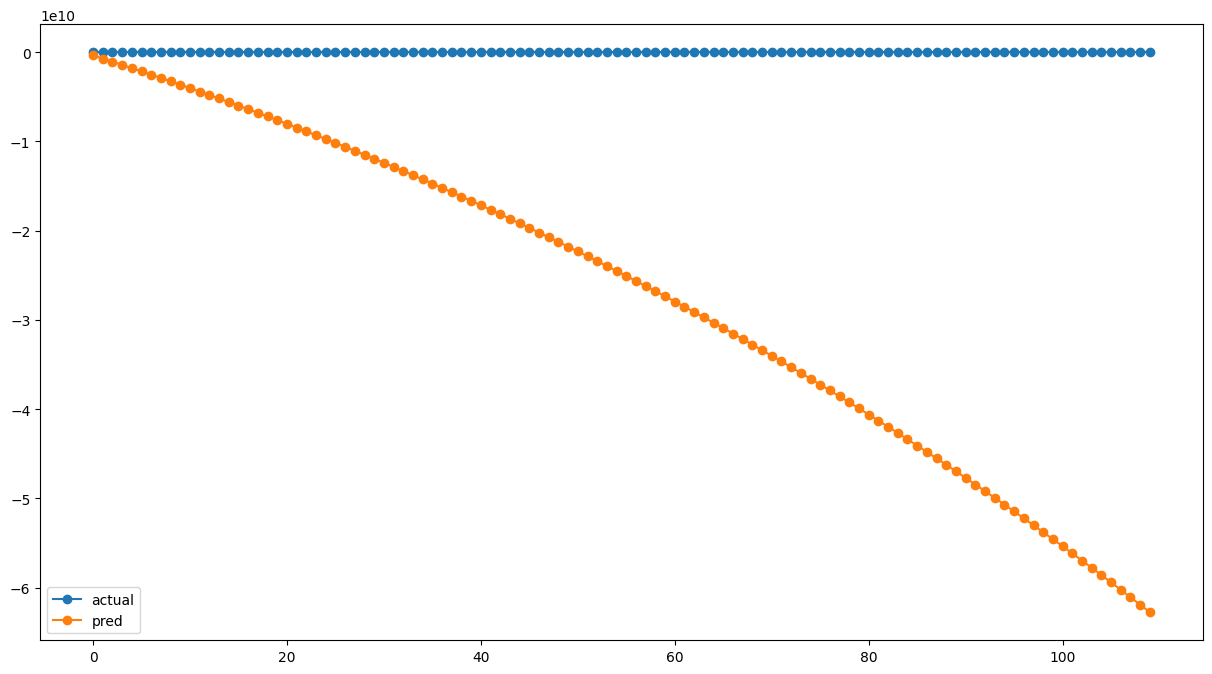

In [595]:
model_no = 5
mod = sarima_model[model_no]
test_act = test_time_series_data[model_no][page_listing[model_no]]
diff_factor = st_factor_index(test_time_series_data[model_no].columns[1])
train_last_val = train_time_series_data[model_no][page_listing[model_no]].iloc[-diff_factor]
exog = [0 for val in range(len(test_time_series_data[model_no]))]

model_performance(mod, test_act, train_last_val, exog, plot_disp = True)

## Creating SARIMAX Model

In [596]:
pdq = list((p, d, q) for p in range(1, 4) for d in range(1, 4) for q in range(1, 4))
PDQS = list((P, D, Q, S) for P in range(2, 4) for D in range(1, 4) for Q in range(1, 4) for S in range(1, 4))

In [599]:
train_time_series_data[5]['exog'].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [600]:
sarimax_model = []
sarimax_pdq = []
for cntr in range(series_count):
    x_train = train_time_series_data[cntr][page_listing[cntr]]
    x_exog = train_time_series_data[cntr]['exog']
    tr_model, tr_pdq = sarimax_gridsearch(x_train, pdq, PDQS, exog=x_exog)
    sarimax_model.append(tr_model)
    sarimax_pdq.append({'pdq' : tr_pdq.iloc[0]['pdq'], 'pdqs' : tr_pdq.iloc[0]['pdqs'], 'bic' : tr_pdq.iloc[0]['bic']})

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average compone

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater tha

Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregres

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average compone

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater tha

Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregres

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average compone

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater tha

Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregres

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average compone

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater tha

Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregres

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average compone

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater tha

Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregres

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average compone

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater tha

Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregres

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average compone

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater tha

Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregres

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average compone

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater tha

Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregres

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average compone

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater tha

Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregres

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average compone

Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater than 1.
Invalid model: moving average lag(s) {2} are in both the seasonal and non-seasonal moving average components.
Seasonal periodicity must be greater tha

Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.
Seasonal periodicity must be greater than 1.
Invalid model: autoregres

In [601]:
sarimax_pdq

[{'pdq': (2, 1, 2), 'pdqs': (3, 1, 1, 3), 'bic': 4039.6543872491866},
 {'pdq': (2, 1, 2), 'pdqs': (3, 1, 3, 3), 'bic': 8175.046890722974},
 {'pdq': (2, 1, 1), 'pdqs': (3, 1, 2, 3), 'bic': 6290.312003814546},
 {'pdq': (2, 1, 2), 'pdqs': (3, 1, 3, 3), 'bic': 6727.19360525287},
 {'pdq': (2, 1, 2), 'pdqs': (3, 1, 3, 3), 'bic': 6083.942150703274},
 {'pdq': (2, 2, 1), 'pdqs': (3, 3, 2, 3), 'bic': 339.6468630154768},
 {'pdq': (2, 1, 2), 'pdqs': (3, 1, 3, 3), 'bic': 7596.070752738223},
 {'pdq': (2, 1, 1), 'pdqs': (3, 1, 2, 3), 'bic': 6084.235160824701},
 {'pdq': (2, 1, 2), 'pdqs': (3, 1, 1, 3), 'bic': 6448.758884546475},
 {'pdq': (2, 1, 2), 'pdqs': (3, 1, 1, 3), 'bic': 2925.532776985803}]

MAE : 44.733
RMSE : 57.476
MAPE: 3380818753905837.5


3380818753905837.5

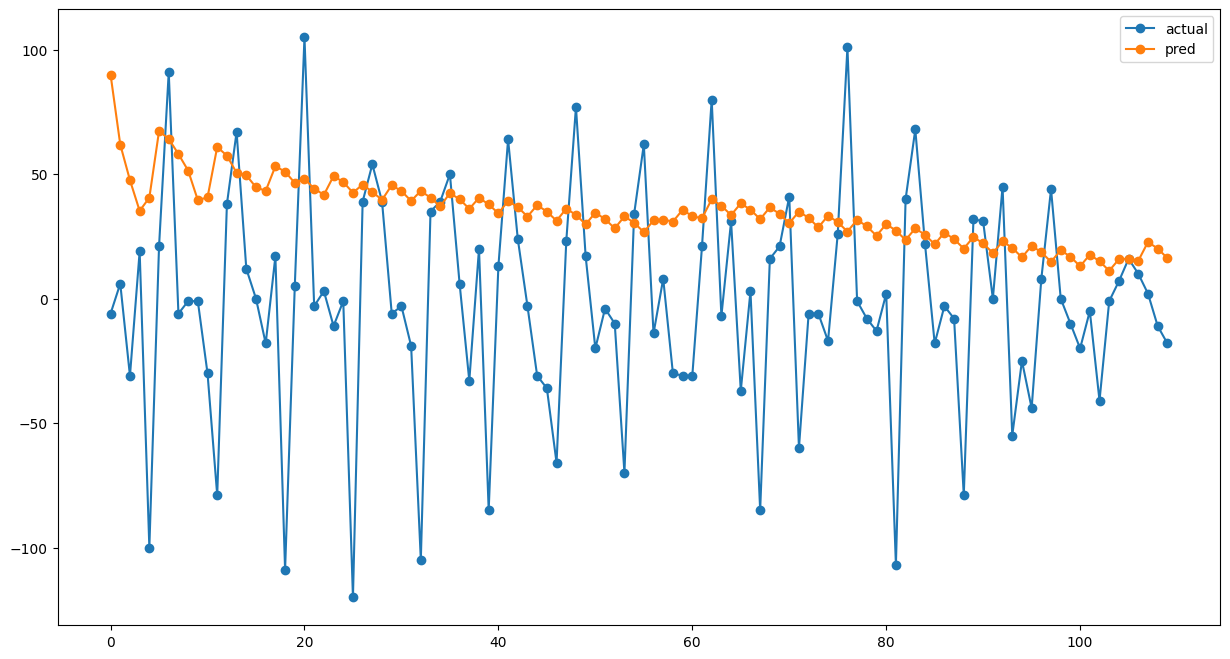

In [602]:
model_no = 0
mod = sarimax_model[model_no]
test_act = test_time_series_data[model_no][page_listing[model_no]]
diff_factor = st_factor_index(test_time_series_data[model_no].columns[1])
train_last_val = train_time_series_data[model_no][page_listing[model_no]].iloc[-diff_factor]
exog = test_time_series_data[model_no]['exog']

model_performance(mod, test_act, train_last_val, exog, plot_disp = True)

# train_time_series_data[model_no][page_listing[model_no]].iloc[-1]

In [604]:
sarimax_mape_lst = []
for cntr in range(series_count):
    mod = sarimax_model[cntr]
    test_act = test_time_series_data[cntr][page_listing[cntr]]
    diff_factor = st_factor_index(test_time_series_data[cntr].columns[1])
    train_last_val = train_time_series_data[cntr][page_listing[cntr]].iloc[-diff_factor]
    exog = test_time_series_data[cntr]['exog']

    
 
    sarimax_mape_lst.append(model_performance(mod, test_act, train_last_val, exog, plot_disp = False))
    
print('MAPE Score of MA Model:', sarima_mape_lst)

MAPE Score of MA Model: [1.9283217962299852e+16, 231140046.8, 112.928, 1.8219107583453396e+16, 2.06683296591033e+24, 5.708838164790922e+24, 1.0152417654000813e+17, 4.457715892467444e+17, 4.701752524520216e+16, 2203889179351520.2]


MAE : 732887103714.325
RMSE : 880929329382.793
MAPE: 1.5438284406140013e+26


1.5438284406140013e+26

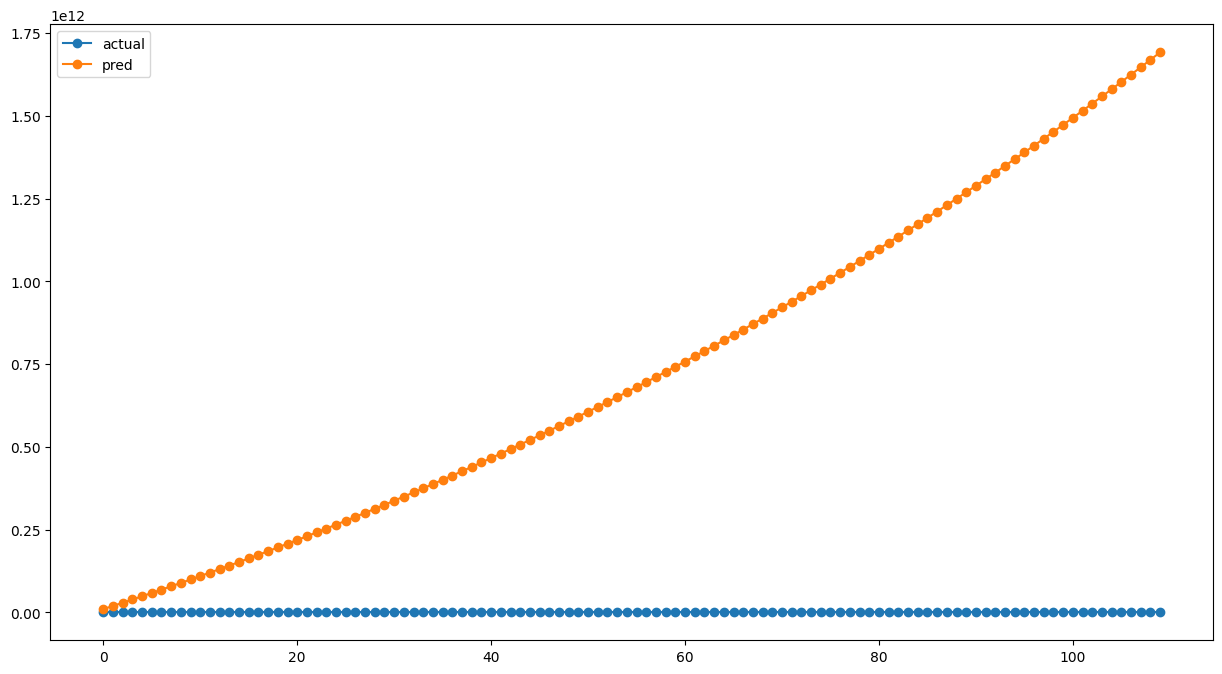

In [605]:
model_no = 5
mod = sarimax_model[model_no]
test_act = test_time_series_data[model_no][page_listing[model_no]]
diff_factor = st_factor_index(test_time_series_data[model_no].columns[1])
train_last_val = train_time_series_data[model_no][page_listing[model_no]].iloc[-diff_factor]
exog = test_time_series_data[model_no]['exog']

model_performance(mod, test_act, train_last_val, exog, plot_disp = True)